# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [122]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        #hv = HashingVectorizer(n_features=2 ** 20, alternate_sign=False, lowercase = False, ngram_range = (1,2))
        hv = HashingVectorizer(n_features=2 ** 14, alternate_sign=False, lowercase = False, stop_words = 'english')
        hv = HashingVectorizer(n_features=2 ** 16, alternate_sign=False, lowercase = False, ngram_range = (1,2))
        hv = HashingVectorizer(analyzer = 'char_wb', n_features=2 ** 16, alternate_sign=False, lowercase = False, ngram_range = (1,15))


        #hv = CountVectorizer(lowercase = False, stop_words = 'english')


        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")

    X_quant_features = toxic_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [123]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='./mats/toxiccomments_train.csv', my_random_seed=13)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

### 20*2

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [5]:

from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)


{'Pos': 13063, 'Neg': 114593, 'TP': 6179, 'TN': 58740, 'FP': 55853, 'FN': 6884, 'Accuracy': 0.5085464059660337, 'Precision': 0.09960987877224659, 'Recall': 0.4730153869708337, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [100]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 13063, 'Neg': 114593, 'TP': 12453, 'TN': 114032, 'FP': 561, 'FN': 610, 'Accuracy': 0.9908269098201417, 'Precision': 0.9568925772245275, 'Recall': 0.9533032228431447, 'desc': 'svm_train'}


### MODEL: logistic regression

In [101]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 13063, 'Neg': 114593, 'TP': 12572, 'TN': 114191, 'FP': 402, 'FN': 491, 'Accuracy': 0.9930046374631823, 'Precision': 0.9690149529828889, 'Recall': 0.9624129219934165, 'desc': 'lgs_train'}


# SVC with 1e-4 C

In [69]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

SVC_4 = SVC(C = 1e-4, max_iter = 1e5)
SVC_4.fit(X_train, y_train)

SVC_4_performance_train_1 = BinaryClassificationPerformance(SVC_4.predict(X_train), y_train, 'SVC_4_train')
SVC_4_performance_train_1.compute_measures()
print(SVC_4_performance_train_1.performance_measures)

{'Pos': 13063, 'Neg': 114593, 'TP': 0, 'TN': 114593, 'FP': 0, 'FN': 13063, 'Accuracy': 0.8976703014351068, 'Precision': nan, 'Recall': 0.0, 'desc': 'SVC_4_train'}


/Users/chooseimage/Documents/Course22/ML/ml/final_assignment_1/my_measures.py:25: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])


### MODEL: Naive Bayes

In [124]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB(alpha = 0.0001)
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 13063, 'Neg': 114593, 'TP': 10798, 'TN': 105672, 'FP': 8921, 'FN': 2265, 'Accuracy': 0.9123738798019678, 'Precision': 0.5475936913636594, 'Recall': 0.8266095077700375, 'desc': 'nbs_train'}


### 20*2

### MODEL: Perceptron

In [103]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 13063, 'Neg': 114593, 'TP': 12291, 'TN': 113934, 'FP': 659, 'FN': 772, 'Accuracy': 0.9887901861252115, 'Precision': 0.9491119691119692, 'Recall': 0.9409017836637832, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [104]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 13063, 'Neg': 114593, 'TP': 8162, 'TN': 114121, 'FP': 472, 'FN': 4901, 'Accuracy': 0.9579103214890017, 'Precision': 0.9453324067639565, 'Recall': 0.6248181887774631, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [73]:
'''
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)
'''

"\nfrom sklearn.ensemble import RandomForestClassifier\nrdf = RandomForestClassifier(max_depth=2, random_state=0)\nrdf.fit(X_train, y_train)\n\nrdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')\nrdf_performance_train.compute_measures()\nprint(rdf_performance_train.performance_measures)\n"

### ROC plot to compare performance of various models and fits

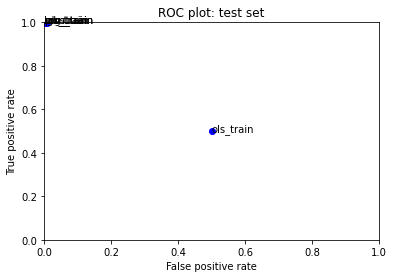

In [74]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [105]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 3162, 'Neg': 28753, 'TP': 1663, 'TN': 13579, 'FP': 15174, 'FN': 1499, 'Accuracy': 0.4775810747297509, 'Precision': 0.09877056482746333, 'Recall': 0.5259329538266919, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [106]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3162, 'Neg': 28753, 'TP': 2021, 'TN': 27109, 'FP': 1644, 'FN': 1141, 'Accuracy': 0.9127369575434748, 'Precision': 0.5514324693042292, 'Recall': 0.6391524351676154, 'desc': 'svm_test'}


### MODEL: logistic regression

In [107]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 3162, 'Neg': 28753, 'TP': 2020, 'TN': 27084, 'FP': 1669, 'FN': 1142, 'Accuracy': 0.9119222935923547, 'Precision': 0.5475738682569802, 'Recall': 0.6388361796331435, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [19]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3162, 'Neg': 28753, 'TP': 2281, 'TN': 24513, 'FP': 4240, 'FN': 881, 'Accuracy': 0.8395425348582172, 'Precision': 0.34979297653734087, 'Recall': 0.7213788741302973, 'desc': 'nbs_test'}


In [24]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3162, 'Neg': 28753, 'TP': 2301, 'TN': 25390, 'FP': 3363, 'FN': 861, 'Accuracy': 0.8676484411718628, 'Precision': 0.40625, 'Recall': 0.7277039848197343, 'desc': 'nbs_test'}


In [28]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3162, 'Neg': 28753, 'TP': 2297, 'TN': 25212, 'FP': 3541, 'FN': 865, 'Accuracy': 0.8619457935140217, 'Precision': 0.3934566632408359, 'Recall': 0.7264389626818469, 'desc': 'nbs_test'}


### ngram 1,2

In [33]:


nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3162, 'Neg': 28753, 'TP': 2440, 'TN': 25360, 'FP': 3393, 'FN': 722, 'Accuracy': 0.8710637631207896, 'Precision': 0.4183096176924396, 'Recall': 0.7716635041113219, 'desc': 'nbs_test'}


### ngram 1,3

In [39]:


nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3162, 'Neg': 28753, 'TP': 2388, 'TN': 25291, 'FP': 3462, 'FN': 774, 'Accuracy': 0.867272442425192, 'Precision': 0.4082051282051282, 'Recall': 0.7552182163187856, 'desc': 'nbs_test'}


### ngram 1,2  , 2*13

In [63]:


nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3162, 'Neg': 28753, 'TP': 2469, 'TN': 25092, 'FP': 3661, 'FN': 693, 'Accuracy': 0.8635751214162619, 'Precision': 0.40277324632952693, 'Recall': 0.7808349146110057, 'desc': 'nbs_test'}


### ngram 1,2  , 2*15

In [67]:


nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3162, 'Neg': 28753, 'TP': 2383, 'TN': 25742, 'FP': 3011, 'FN': 779, 'Accuracy': 0.8812470625097917, 'Precision': 0.4417871709306637, 'Recall': 0.7536369386464263, 'desc': 'nbs_test'}


### char_wb ngram 1,2  , 2*15

In [84]:


nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3162, 'Neg': 28753, 'TP': 2467, 'TN': 26382, 'FP': 2371, 'FN': 695, 'Accuracy': 0.9039323202255992, 'Precision': 0.5099214551467549, 'Recall': 0.7802024035420619, 'desc': 'nbs_test'}


### char_wb ngram 1,10  , 2*15

In [80]:


nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3162, 'Neg': 28753, 'TP': 2467, 'TN': 26387, 'FP': 2366, 'FN': 695, 'Accuracy': 0.9040889863700454, 'Precision': 0.5104489964825161, 'Recall': 0.7802024035420619, 'desc': 'nbs_test'}


### char_wb ngram 1,15  , 2*20

In [90]:


nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3162, 'Neg': 28753, 'TP': 1056, 'TN': 27788, 'FP': 965, 'FN': 2106, 'Accuracy': 0.903775654081153, 'Precision': 0.5225136071251856, 'Recall': 0.33396584440227706, 'desc': 'nbs_test'}


### char_wb ngram 1,15  , 2*16

In [94]:


nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3162, 'Neg': 28753, 'TP': 2500, 'TN': 26369, 'FP': 2384, 'FN': 662, 'Accuracy': 0.904558984803384, 'Precision': 0.5118755118755118, 'Recall': 0.7906388361796332, 'desc': 'nbs_test'}


### char_wb ngram 1,15  , 2*16

In [125]:


nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3162, 'Neg': 28753, 'TP': 2500, 'TN': 26369, 'FP': 2384, 'FN': 662, 'Accuracy': 0.904558984803384, 'Precision': 0.5118755118755118, 'Recall': 0.7906388361796332, 'desc': 'nbs_test'}


### char_wb ngram 1,15  , 2*17

In [110]:


nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3162, 'Neg': 28753, 'TP': 2468, 'TN': 26472, 'FP': 2281, 'FN': 694, 'Accuracy': 0.9067836440545198, 'Precision': 0.5196883554432512, 'Recall': 0.7805186590765338, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [109]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 3162, 'Neg': 28753, 'TP': 2015, 'TN': 27085, 'FP': 1668, 'FN': 1147, 'Accuracy': 0.9117969606767977, 'Precision': 0.5471083355959815, 'Recall': 0.6372549019607843, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [110]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 3162, 'Neg': 28753, 'TP': 1651, 'TN': 28487, 'FP': 266, 'FN': 1511, 'Accuracy': 0.9443208522638258, 'Precision': 0.8612415232133542, 'Recall': 0.5221378874130297, 'desc': 'rdg_test'}


In [83]:
SVC_4_test = BinaryClassificationPerformance(SVC_4.predict(X_test), y_test, 'SVC_4_test')
SVC_4_test.compute_measures()
print(SVC_4_test.performance_measures)

{'Pos': 3162, 'Neg': 28753, 'TP': 0, 'TN': 28753, 'FP': 0, 'FN': 3162, 'Accuracy': 0.9009243302522325, 'Precision': nan, 'Recall': 0.0, 'desc': 'SVC_4_test'}


/Users/chooseimage/Documents/Course22/ML/ml/final_assignment_1/my_measures.py:25: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])


### MODEL: Random Forest Classifier

In [81]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

ValueError: X has 1048578 features, but DecisionTreeClassifier is expecting 16386 features as input.

### ROC plot to compare performance of various models and fits

### n_features=2 ** 20, alternate_sign=False, lowercase = False, stop_words = 'english', ngram_range = (1,2)

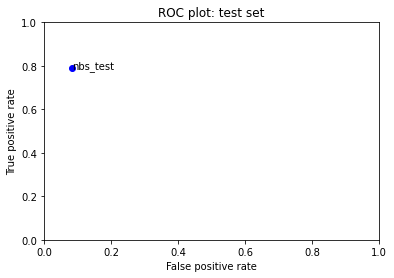

In [126]:
fits_cv = [nbs_performance_test]

for fit in fits_cv:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### n_features=2 ** 14, alternate_sign=False, lowercase = False, stop_words = 'english', ngram_range = (1,2)

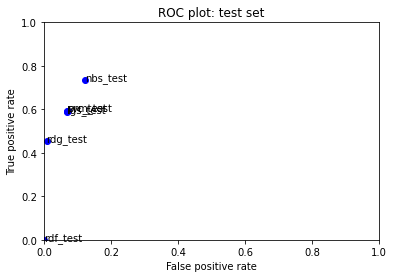

In [63]:
fits_cv = [svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits_cv:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### n_features=2 ** 14, alternate_sign=False, lowercase = False, stop_words = 'english'

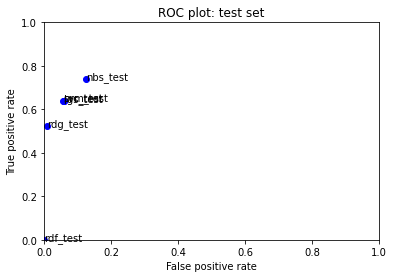

In [111]:
fits_cv = [svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits_cv:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### CountV + stopwordsEnglish + noLowercase

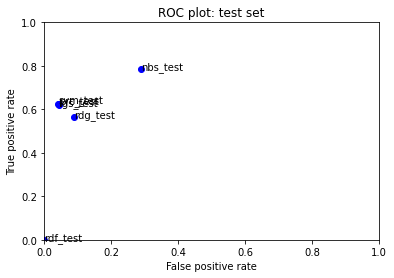

In [25]:
fits_cv = [svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits_cv:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### 2 **7

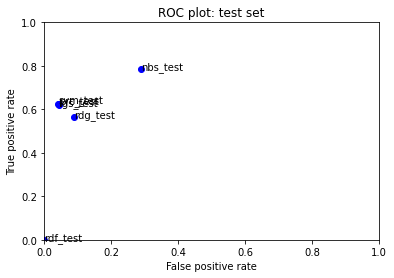

In [24]:
fits_7 = [svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits_7:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### 2 ** 13

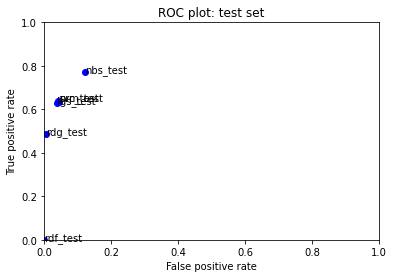

In [103]:
fits_13 = [svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits_13:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### 2 ** 20

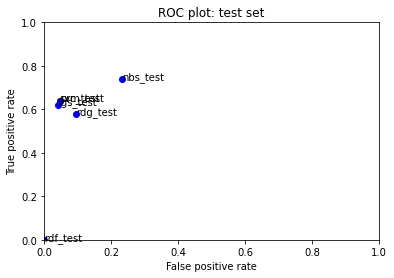

In [82]:
fits = [svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [128]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='./mats/toxiccomments_test.csv', my_random_seed=13, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 65536)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0          72          10
1          13           1
2          16           0
3          38           3
4           7           1
5          16           2
6          31           4
7           6        

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [129]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = nbs.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.24915776553237054


In [130]:
raw_data.head()

,id,comment_text,word_count,punc_count
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,72,10
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,13,1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",16,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",38,3
4,00017695ad8997eb,I don't anonymously edit articles at all.,7,1


In [131]:
my_submission.head()

,id,prediction
0,00001cee341fdb12,True
1,0000247867823ef7,False
2,00013b17ad220c46,False
3,00017563c3f7919a,False
4,00017695ad8997eb,False


In [132]:
my_submission.shape

(153164, 2)

In [133]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('2nd_toxiccomments_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation